In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame as df

import json

In [2]:
timing_data = json.load(open("initial_timing_results.json","r"))

In [11]:
time_df = df(timing_data)

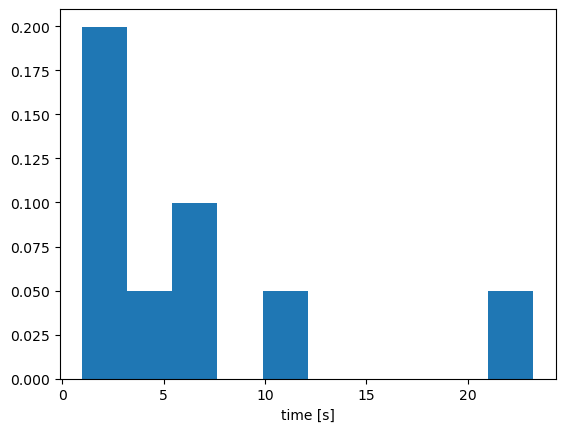

In [18]:
plt.hist(time_df['fd_time'], density=True)
plt.xlabel('time [s]')
plt.show()

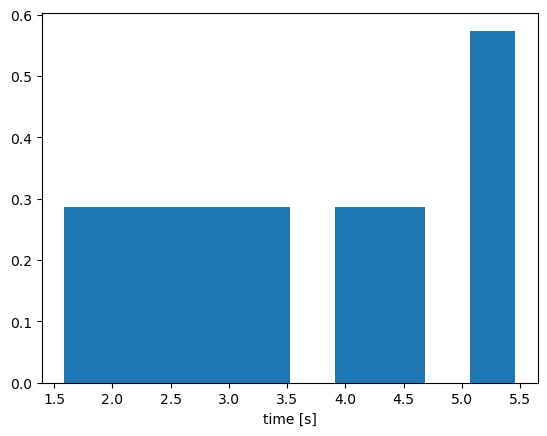

In [17]:
plt.hist(time_df['td_time'], density=True)
plt.xlabel('time [s]')
plt.show()

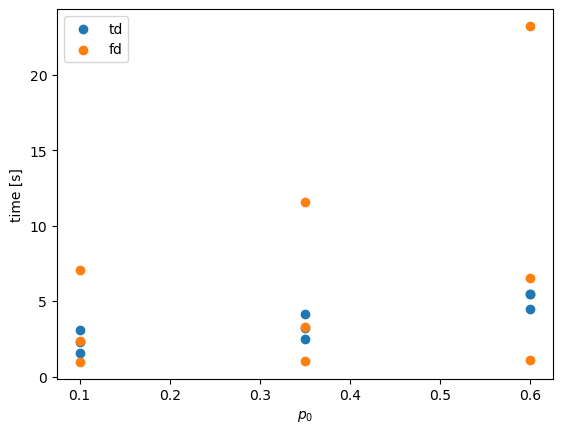

In [31]:
tmp = time_df[['mass_1', 'p0', 'td_time','fd_time']].to_numpy()
plt.scatter(tmp.T[1], tmp.T[2], c='tab:blue', label='td')
plt.scatter(tmp.T[1], tmp.T[3], c='tab:orange', label='fd')
plt.xlabel(r'$p_0$')
plt.ylabel('time [s]')
plt.legend()
plt.show()